<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_ReinfLearn_Work/blob/main/TP01/taxi_qlearning_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.6 MB/s eta 0:00:00


In [3]:
## Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output
import time


In [4]:
## Constants

RENDER_RGB = 'rgb_array'
RENDER_ANSI = 'ansi'

GAME_TAXI = 'Taxi-v3'

In [5]:
## create env (rgb or ansi)

def create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=False):
    if pPrint:
        print('[create_env] Creating environment...')
    try:
        env = gym.make(pGame, render_mode=pRenderMode)
        if pPrint:
            print('[create_env] Environment created successfully!')
        return env
    except Exception as e:
        print('[create_env] Error creating environment:', e)

## Functions to decode state (0-499) into taxi position, passenger position, destination position

In [67]:
## transform passenger and destination into (row, col)
def passenger_to_coordinates(location):
    if location == 0: return (0, 0)
    elif location == 1: return (0, 4)
    elif location == 2: return (4, 0)
    elif location == 3: return (4, 3)
    elif location == 4: return (4, 4)
    elif location == 5: return (-1, -1)  # Special case for inside the taxi
    else: raise ValueError("Invalid location")

def destination_to_coordinates(destination):
    if destination == 0: return (0, 0)
    elif destination == 1: return (0, 4)
    elif destination == 2: return (4, 0)
    elif destination == 3: return (4, 4)
    else: raise ValueError("Invalid destination")

def decode_state(pState, pPrint=False):
    # Taxi position
    taxi_row = pState // (5 * 5 * 4)  # 5 rows * 5 cols * 4 destinations (passenger_loc is 5 or less)
    pState %= 5 * 5 * 4

    taxi_col = pState // (5 * 4)  # 5 cols * 4 destinations
    pState %= 5 * 4

    # Passenger location
    passenger_loc = pState // 4  # passenger location is 0-5
    if passenger_loc == 5:
        passenger_loc = -1  # -1 represents the passenger is in the taxi

    # Destination
    destination = pState % 4  # destination is 0-3

    if pPrint:
        print(f'taxi position: {(taxi_row, taxi_col)}')
        print(f'passenger: {passenger_to_coordinates(passenger_loc)}')
        print(f'destination: {destination_to_coordinates(destination)}')


    return taxi_row, taxi_col, passenger_loc, destination

def plot_reward_evolution(rewards
                          , pXLabel = 'Episode'
                          , pYLabel = 'Reward'
                          , pTitle='Reward Evolution during Training'):
  """Plots the evolution of rewards over episodes.

  Args:
    rewards: A list of rewards obtained during training.
  """
  plt.clf() #clear cell
  plt.plot(rewards)
  plt.xlabel(pXLabel)
  plt.ylabel(pYLabel)
  plt.title(pTitle)

  # Calculate tick positions for 10 evenly spaced labels
  num_ticks = 10
  x_min = 0  # Assume x-axis starts at 0
  x_max = len(rewards) - 1  # Assume x-axis ends at the last data point
  tick_positions = np.linspace(x_min, x_max, num_ticks, dtype=int)

   # Set x-axis ticks and labels
  plt.xticks(tick_positions, tick_positions)  # Set both positions and labels


  plt.show()

  ## only used for rgb (graphical) rendering
def display_rgb(pEnv=create_env(), pPrintMultipleFrames=False):
    print('----------------')
    print('[display_rgb]')
    print('----------------')
    if pEnv.render_mode == RENDER_RGB:
        # Capture the frame for rendering
        frame = env.render()

        # Display the frame in Jupyter
        plt.imshow(frame)
        plt.axis('off')
        display(plt.gcf())
        if pPrintMultipleFrames:
            clear_output(wait=True)  # Clears the output for each frame
        time.sleep(0.1)  # Adjust for slower or faster playback

def plot_frames(frames, columns=4):
    rows = (len(frames) + columns - 1) // columns  # Calculate rows needed
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    fig.tight_layout(pad=0.2)

    for i, frame in enumerate(frames):
        row, col = divmod(i, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(frame)
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * columns):
        row, col = divmod(j, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.show()

# Q-learning

In [68]:


def create_q_table(env):
  """Creates a Q-table with all values initialized to 0.

  Args:
    env: The Gymnasium environment.

  Returns:
    A NumPy array representing the Q-table.
  """
  return np.zeros([env.observation_space.n, env.action_space.n])



def get_policy(q_table, state, epsilon):
  """Selects an action using the epsilon-greedy policy.

  Args:
    q_table: The Q-table containing learned values.
    state: The current state of the environment.
    epsilon: The exploration rate.

  Returns:
    The action selected by the policy.
  """
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # Explore action space
  else:
    action = np.argmax(q_table[state])  # Exploit learned values
  return action



def train_q_learning(env
                     , q_table
                     , alpha=0.1
                     , gamma=0.9
                     , epsilon=1.0
                     , episodes=100000
                     , pPrint=False
                     ):
  """Trains the Q-learning agent.

  Args:
    env: The Gymnasium environment.
    q_table: The Q-table to update.
    alpha: The learning rate.
    gamma: The discount factor.
    epsilon: The exploration rate.
    episodes: The number of training episodes.

    Returns:
    A tuple containing the trained Q-table and the list of rewards per episode.
  """

  rewards = []

  # List to store rewards per episode
  all_rewards_per_episode = []

  # Example decay rate
  epsilon_decay = 0.9999


  for i in range(1, episodes + 1):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    done = False


    while not done:

      action = get_policy(q_table, state, epsilon)

      # Decay epsilon over time:
      epsilon *= epsilon_decay
      epsilon = max(epsilon, 0.1) # set the min epsilon

      ## step
      next_state, reward, done, truncated, info = env.step(action)


      old_value = q_table[state, action]
      next_max = np.max(q_table[next_state])

      ## 'learning' (update q_table)
      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
      q_table[state, action] = new_value

      # reward -10 = leaving passenger somewhere else than destination
      if reward == -10:
        penalties += 1

      state = next_state
      epochs += 1

      rewards.append(reward)



    if pPrint:
      print("****************************************************")
      print(f"Episode: {i}")
      print(f"Timesteps taken: {epochs}")
      print(f"Penalties incurred: {penalties}")


    all_rewards_per_episode.append(np.mean(rewards)) # Calculating avg. reward per episode

    ten_pct_print = int(episodes/10)

    if i % (ten_pct_print) == 0:
      #print(f"Episode: {i}")
      avg_reward_last_100 = np.mean(all_rewards_per_episode[-ten_pct_print:]) # Calculating avg. reward for the last 100 episodes
      print(f"Episode: {i}, Average reward (last {ten_pct_print} episodes): {avg_reward_last_100}, current epsilon: {epsilon}")


    #if i % 1000 == 0:
     # plot_reward_evolution(rewards)

  print("Training finished.\n")
  return q_table, all_rewards_per_episode  # Return the Q-table and reward history




def evaluate_agent(env
                   , q_table
                   , episodes=100
                   , pPrint=False
                   , pPlotGame=False
                   , pPlotGraphs=False
                   , pDecodeState=False):
  """Evaluates the trained agent.

  Args:
    env: The Gymnasium environment.
    q_table: The trained Q-table.
    episodes: The number of evaluation episodes.

  Returns:
    The average reward over the evaluation episodes.
  """

  if pPrint:
      print('Evaluating agent...')

  arr_avg_rewards = []
  arr_total_rewards = []
  arr_total_steps = []
  arr_penalties = []

  ## to print all at once
  arr_frames=[]

  total_rewards = 0
  for ep in range(episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    steps_so_far = 0
    penalties = 0

    ## render game image
    if pPlotGame:
      ##display_rgb(env, pPrintMultipleFrames=True)
      arr_frames.append(env.render())

    ## print taxi, passenger and destination coords
    if pDecodeState:
      decode_state(state, pPrint=True)

    while not done :
      action = np.argmax(q_table[state])

      ## step
      state, reward, done, truncated, info = env.step(action)

      ## render game image
      if pPlotGame:
        ## display_rgb(env, pPrintMultipleFrames=True)
        arr_frames.append(env.render())

      ## print taxi, passenger and destination coords
      if pDecodeState:
        decode_state(state, pPrint=True)

      steps_so_far +=1

      if steps_so_far>30:
        print(f'Too many steps {steps_so_far} Bye')
        done = True

      episode_reward += reward

      if reward == -10:
        penalties += 1
        if penalties >3:
          print(f'Too many wrong actions {penalties}. Bye!')
          done = True

      reward_per_step = episode_reward / steps_so_far


      if (pPrint and (steps_so_far % 50) ==0):
        print(f'steps_so_far: {steps_so_far}')
        print(f'Reward/step in episode [{ep}]: {reward_per_step}')

    total_rewards += episode_reward

    if pPrint:
      print(f"Episode [{ep}] [reward]: {episode_reward} - [reward/step]: {reward_per_step} - [penalties]: {penalties} - [total_steps]: {steps_so_far}")


    arr_total_steps.append(steps_so_far)
    arr_penalties.append(penalties)
    arr_avg_rewards.append(reward_per_step)
    arr_total_rewards.append(episode_reward)

  print(f"Results after {episodes} episodes:")
  print(f'len(arr_avg_rewards): {len(arr_avg_rewards)} ')
  print(f'len(arr_total_rewards): {len(arr_total_rewards)} ')
  print(f'len(arr_total_steps): {len(arr_total_steps)} ')
  print(f'len(arr_penalties): {len(arr_penalties)} ')

  ## render game image
  if pPlotGame:
    plot_frames(arr_frames)

  if pPlotGraphs:
    plot_reward_evolution(arr_avg_rewards
                          , pYLabel='Average Reward'
                          , pTitle='Average Reward evolution')
    plot_reward_evolution(arr_total_rewards
                          , pYLabel='Total Rewards'
                          , pTitle='Total Rewards evolution')
    plot_reward_evolution(arr_total_steps
                          , pYLabel='Total Steps'
                          , pTitle='Total Steps evolution')
    plot_reward_evolution(arr_penalties
                          , pYLabel='Penalties'
                          , pTitle='Penalties evolution')

  return total_rewards / episodes



In [40]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=5000)
q_table2, rewards2 = train_q_learning(env, create_q_table(env), episodes=7500)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 500, Average reward (last 500 episodes): -1.7136055199395543, current epsilon: 0.1
Episode: 1000, Average reward (last 500 episodes): -1.400665932272186, current epsilon: 0.1
Episode: 1500, Average reward (last 500 episodes): -1.2810836766233273, current epsilon: 0.1
Episode: 2000, Average reward (last 500 episodes): -1.183656521138246, current epsilon: 0.1
Episode: 2500, Average reward (last 500 episodes): -1.0966740526240624, current epsilon: 0.1
Episode: 3000, Average reward (last 500 episodes): -1.0220816360768112, current epsilon: 0.1
Episode: 3500, Average reward (last 500 episodes): -0.9564404864561838, current epsilon: 0.1
Episode: 4000, Average reward (last 500 episodes): -0.8965427369088723, current epsilon: 0.1
Episode: 4500, Average reward (last 500 episodes): -0.8426993069754828, current epsilon: 0.1
Episode: 5000, Average reward (last 500 episodes): -0.7931666817115672, current ep

In [41]:
## q_table 1
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=200
                                ,  pPrint=True
                                )

print(f"Average reward: {average_reward}")



Evaluating agent...
Episode [0] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [1] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [2] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [3] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [4] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [5] [reward]: 13 - [reward/step]: 1.625 - [penalties]: 0 - [total_steps]: 8
Episode [6] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [7] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [8] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [9] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [10] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [11] [reward]: 12 -

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


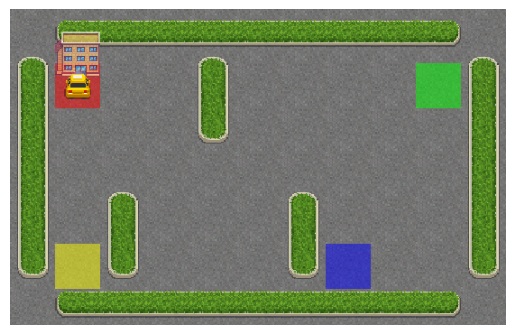

In [42]:
## plot the game
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True)
env.close()

In [17]:
## q_table 2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [1] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [2] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [3] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [4] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [5] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [6] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [7] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [8] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [9] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [10] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps

In [26]:
## plot the game
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True)

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


Combining training 1 & 2.

In [62]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=3000)
q_table2, rewards2 = train_q_learning(env, q_table1, episodes=3500)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 300, Average reward (last 300 episodes): -1.8615324791576215, current epsilon: 0.1
Episode: 600, Average reward (last 300 episodes): -1.5070018119011463, current epsilon: 0.1
Episode: 900, Average reward (last 300 episodes): -1.4109551739112582, current epsilon: 0.1
Episode: 1200, Average reward (last 300 episodes): -1.3368457101252815, current epsilon: 0.1
Episode: 1500, Average reward (last 300 episodes): -1.2698075561954563, current epsilon: 0.1
Episode: 1800, Average reward (last 300 episodes): -1.209674947051903, current epsilon: 0.1
Episode: 2100, Average reward (last 300 episodes): -1.1556532904509573, current epsilon: 0.1
Episode: 2400, Average reward (last 300 episodes): -1.1065239563353915, current epsilon: 0.1
Episode: 2700, Average reward (last 300 episodes): -1.0601976194332001, current epsilon: 0.1
Episode: 3000, Average reward (last 300 episodes): -1.0180512223016236, current eps

In [63]:
## q_table 1_2
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [1] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [2] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [3] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [4] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [6] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [7] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [8] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [9] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [10] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [11] [

taxi position: (2, 2)
passenger: (4, 3)
destination: (0, 0)
taxi position: (2, 3)
passenger: (4, 3)
destination: (0, 0)
taxi position: (3, 3)
passenger: (4, 3)
destination: (0, 0)
taxi position: (4, 3)
passenger: (4, 3)
destination: (0, 0)
taxi position: (4, 3)
passenger: (4, 4)
destination: (0, 0)
taxi position: (3, 3)
passenger: (4, 4)
destination: (0, 0)
taxi position: (2, 3)
passenger: (4, 4)
destination: (0, 0)
taxi position: (2, 2)
passenger: (4, 4)
destination: (0, 0)
taxi position: (2, 1)
passenger: (4, 4)
destination: (0, 0)
taxi position: (2, 0)
passenger: (4, 4)
destination: (0, 0)
taxi position: (1, 0)
passenger: (4, 4)
destination: (0, 0)
taxi position: (0, 0)
passenger: (4, 4)
destination: (0, 0)
taxi position: (0, 0)
passenger: (0, 0)
destination: (0, 0)
Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


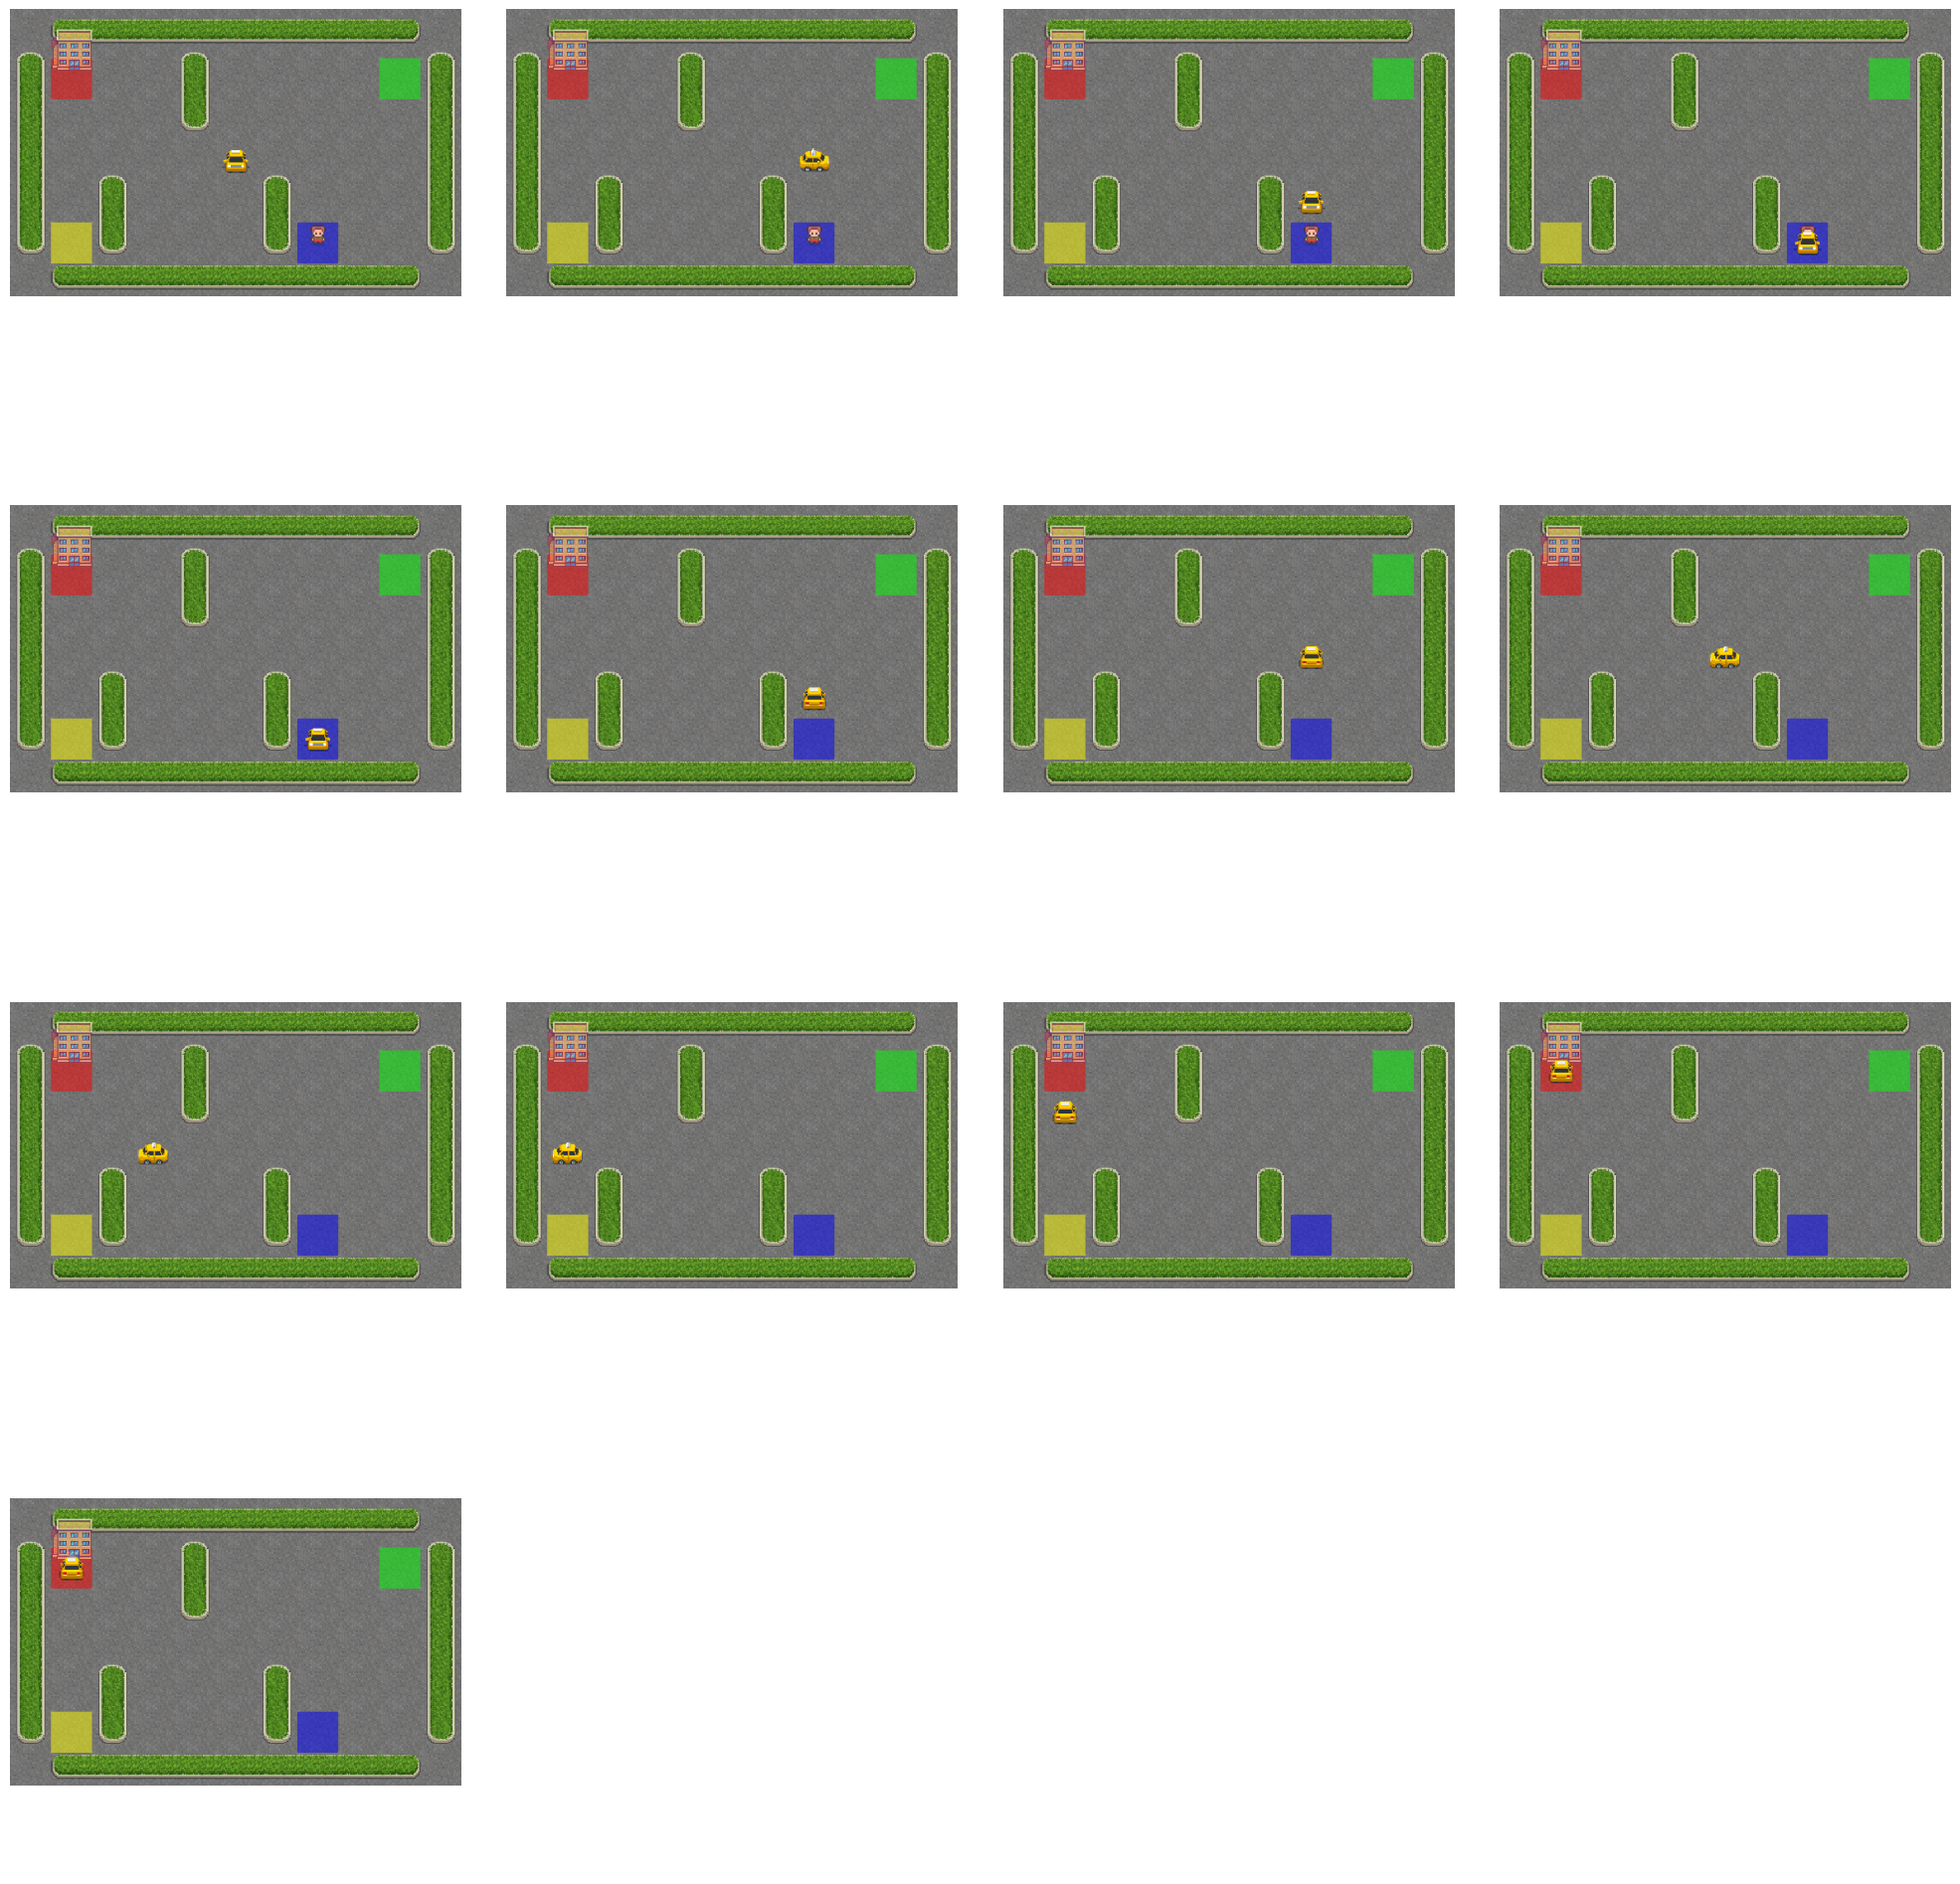

In [69]:
## plot the game
average_reward = evaluate_agent(env
                                , q_table2
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True
                                , pDecodeState=True)
env.close()

Short training

In [49]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=500)


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 50, Average reward (last 50 episodes): -2.488744360835419, current epsilon: 0.1
Episode: 100, Average reward (last 50 episodes): -1.8884024096634702, current epsilon: 0.1
Episode: 150, Average reward (last 50 episodes): -1.7421039147320334, current epsilon: 0.1
Episode: 200, Average reward (last 50 episodes): -1.6696868238692022, current epsilon: 0.1
Episode: 250, Average reward (last 50 episodes): -1.6193955664114172, current epsilon: 0.1
Episode: 300, Average reward (last 50 episodes): -1.582359611355112, current epsilon: 0.1
Episode: 350, Average reward (last 50 episodes): -1.5543114519186105, current epsilon: 0.1
Episode: 400, Average reward (last 50 episodes): -1.530697797376253, current epsilon: 0.1
Episode: 450, Average reward (last 50 episodes): -1.508038839203787, current epsilon: 0.1
Episode: 500, Average reward (last 50 episodes): -1.4877243998090872, current epsilon: 0.1
Training fi

In [50]:
## q_table 1
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=100
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Too many steps 31 Bye
Episode [0] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [1] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [2] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [3] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [4] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Too many steps 31 Bye
Episode [5] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [6] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [7] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye
Episode [8] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [9] [reward]: 10 - [reward/step]:

Too many steps 31 Bye
Episode [0] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 
Average reward: -31.0


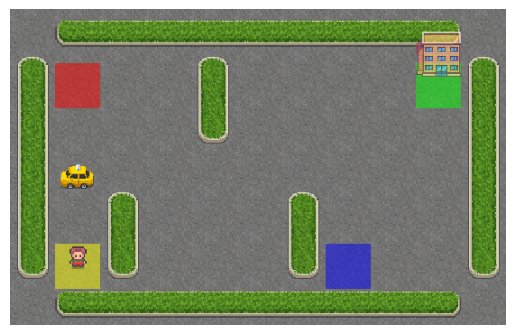

In [51]:
## q_table 1
average_reward = evaluate_agent(env
                                , q_table1
                                , episodes=1
                                ,  pPrint=True
                                , pPlotGame=True)

print(f"Average reward: {average_reward}")
env.close()

Not enough training example